<b> Introduction <b>

A golden cross occurs when a short-term moving average crosses above a long-term moving average. This event marks the possible formation of a long-term bull market and might indicate a good time to buy the analyzed asset. Conversely, a death cross occurs when the short-term moving average crosses below the long-term moving average. This event signals the possible emergence of a long-term bear market and indicates a good time to sell the asset.

Using the golden cross strategy, I've developed a bot that fetches real-time data from the Binance server and calculates, plots, and executes buy/sell signals for a specified asset (in this case, Bitcoin). The bot calculates short (50-day) and long (200-day) moving averages (average closing price of the asset) and utilizes this information to identify when a golden cross or a death cross occurs. When either event occurs, the bot sends an order to the Binance testnet platform to either buy or sell, depending on the type of signal (golden or death cross). Additionally, the bot creates a plot that is updated every minute, showing the closing prices of the asset, moving averages, and buy/sell signals.


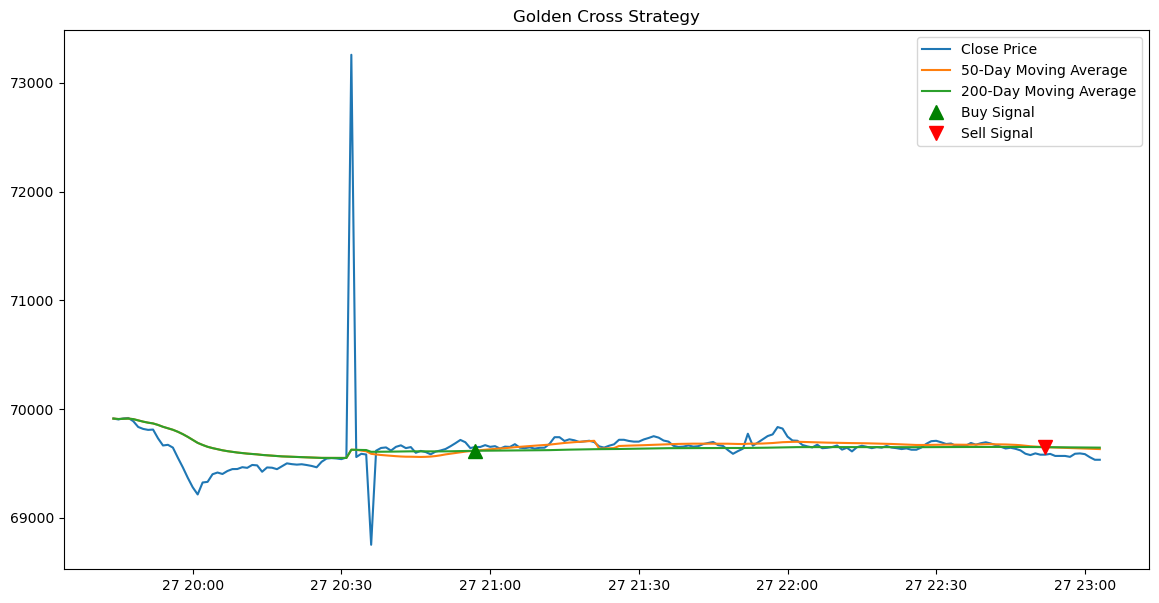

KeyboardInterrupt: 

In [8]:
#Importing libraries
import pandas as pd                       #Data science essentials
import numpy as np                        #Math essentials
import matplotlib.pyplot as plt           #Data visualization essentials
from binance.client import Client         #Binance
from binance.enums import *               #Binance
import time                               #Time control
from IPython.display import clear_output  #Data visualization additionals

#Setting up keys and binance client using testnet
api_key = 'AYRKt9lMqSHWu0xrN2PV5nBzXVB8JpBJNOf20s287OiJgCJ5eLPcd6yDuB2dqJpN'
api_secret = 's99kfQN4Bjr8ww1cSsEriCzfKlHfBWArM6ZhVXiOUpaSgIfnyzBEBkJldmhbhMws'
client = Client(api_key, api_secret, testnet = True)

#Creating the funtion fetch_data to fetch real time data from binance
def fetch_data(symbol, interval, past):
    
    #Setting up the frame
    frame = pd.DataFrame(client.get_historical_klines(symbol, interval, past + ' min ago UTC'))
    
    #Using iloc to extract relevant information
    frame = frame.iloc[:, :5]
    
    #Renaming extracted columns
    frame.columns = ['Time', 'Open', 'High', 'Low', 'Close']
    
    #Setting Time as the index of the dataframe
    frame = frame.set_index('Time')
    
    #Changing the Time column (index) to datetime format
    frame.index = pd.to_datetime(frame.index, unit = 'ms')
    
    #Changing the values in frame to type float to execute calculations
    frame = frame.astype(float)
    
    return frame

#Setting parameters for the moving averages
short_window = 50
long_window = 200

#Defining the function calculate_moving_averages to calculate, well... the moving averages for the short and long window
def calculate_moving_averages(data):

    #Using the rolling and mean methods to calculate the moving averages for the short window
    data['short_mavg'] = data['Close'].rolling(window = short_window, min_periods = 1).mean()

    #Using the rolling and mean methods to calculate the moving averages for the long window
    data['long_mavg']  = data['Close'].rolling(window = long_window,  min_periods = 1).mean()

    return data

#Defining the function generate_signals to signal when a golden cross or a death cross happens
def generate_signals(data):

    #Instantiating the signal column and setting it's value to 0
    data['signal'] = 0

    #Upadating the signal column with a 1 if short_mavg is larger than long_mavg and 0 otherwise
    data['signal'][short_window:] = np.where(data['short_mavg'][short_window:] > data['long_mavg'][short_window:], 1, 0)

    #Creating a positions column to show changes in signal and identify golden cross and death cross instances
    data['positions'] = data['signal'].diff()
    
    return data

#Defining the function execute_trades to execute the buy or sell orders when a golden cross or a death cross is identifed 
def execute_trades(client, symbol, data):

    #Starting from index 1 till the end of the column
    for i in range(1, len(data)):

        #When positions == 1 (A golden cross occurs)
        if data['positions'].iloc[i] == 1:
            
            #Print a text that specifies the time of the buy order and the price of the symbol at the time
            print(f"Buy signal at {data.index[i]}, price: {data['Close'].iloc[i]}")

            #Using order_market_buy to place an order to spend the entire budget on the specified symbol
            order = client.order_market_buy(symbol = symbol, quantity = 1)

        #When positions == -1 (A death cross)
        elif data['positions'].iloc[i] == -1:
            
            #Print a text that specifies the time of the sell order and the price of the symbol at the time
            print(f"Sell signal at {data.index[i]}, price: {data['Close'].iloc[i]}")

            #Using order_market_sell to place an order to liquidate the entirity of the assets owned of the specified symbol
            order = client.order_market_sell(symbol = symbol, quantity = 1)

#Defining a function to continually plot the changes in closing prices, moving averages, and buy/sell signals
def plot_data(data):

    #Stablishing figure size
    plt.figure(figsize = (14, 7))
    
    #Plotting the closing price of the symbol
    plt.plot(data['Close'], label = 'Close Price')

    #Plotting the short moving average
    plt.plot(data['short_mavg'], label = '50-Day Moving Average')

    #Plotting the long moving average
    plt.plot(data['long_mavg'], label = '200-Day Moving Average')
    
    #Plotting buy signals
    plt.plot(data[data['positions'] == 1].index,
             data['short_mavg'][data['positions'] == 1],
             '^', markersize = 10, color = 'g', lw = 0, label = 'Buy Signal') #Setting up marker, color, and label.
    
    #Plotting sell signals
    plt.plot(data[data['positions'] == -1].index,
             data['short_mavg'][data['positions'] == -1],
             'v', markersize = 10, color = 'r', lw = 0, label = 'Sell Signal') #Setting up marker, color, and label.

    #Setting up the title of the plot 
    plt.title('Golden Cross Strategy')

    #Setting up the legend of the plot
    plt.legend()

    #Showing the plot
    plt.show()

#Defining the function run_bot that unifies all the functions created into a "bot" that automatically graphs and executes the trades according to the golden cross strategy
def run_bot(symbol, interval, past):
    while True:

        #Fetching real time data
        data = fetch_data(symbol, interval, past)

        #Calculating moving averages
        data = calculate_moving_averages(data)

        #Generating signals
        data = generate_signals(data)

        #Executing trades
        execute_trades(client, symbol, data)
        
        #Clearing previous outputs of the plot
        clear_output(wait = True)

        #Plotting actualized data
        plot_data(data)
        
        #Setting a 1 minute wait time for the next iteration of the bot
        time.sleep(60)

#Running the bot using Bitcoin (BTCUSDT), 1 minute intervals and data from 200 days ago
run_bot(symbol = 'BTCUSDT', interval = '1m', past = '200')
